In [17]:
import pandas as pd

# sklearn
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, OrdinalEncoder
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report
from sklearn.decomposition import PCA

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

In [2]:
data = pd.read_csv("./data/Exam_Performance_Data.csv", sep=";")
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


In [3]:
# checking for null values
print(data.info(verbose=True))  # to check for null entries

# no null entries where found

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None


In [4]:
# checking for duplicates, since no IDs where given in the dataset
duplicates = data.duplicated().sum()

print(duplicates)

# one duplicate has been found
data.drop_duplicates(inplace=True)  # duplicate will be dropped

1


In [5]:
# test scores will be summarized into a meta score, it might be interesting also to see which score is the most...
# ...impactful
data["Test_Meta_Score"] = data["math score"] + data["reading score"] + data["writing score"]

# test preparation will be converted into a simple binary (dummy) variable 0/1, since its impact can be assumed...
# ...quite clearly; lunch was not changed accordingly, since it is not as clear
data["test preparation course"] = data["test preparation course"].replace({"completed": 1, "none": 0})

# transforming education data for the one hot encoding

data['parental level of education'] = data['parental level of education'].replace({'some high school':'some_high_school','high school': 'high_school','some college':'some_college',"associate's degree":"associate's_degree","bachelor's degree":"bachelor's_degree","master's degree":"master's_degree"})

categorical_cols = ['gender', 'race/ethnicity', 'lunch']
ordinal_cols = ['parental level of education']
numerical_cols = ['test preparation course', 'math score', 'reading score', 'writing score', 'Test_Meta_Score']
# test preperation course is an already one hot encoded variable

In [6]:
# Create a transformer for each data type
# Transfomer for categorical data based on OHC
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False))
])

# Encoding of ordinal data
ordinal_transformer = Pipeline(steps=[
    ("encoder", OrdinalEncoder(categories=[['some_high_school','high_school','some_college',"associate's_degree","bachelor's_degree","master's_degree"]]))
])

# Powertransformer normalises data with the assumtption that data is normaly distributed
numerical_transformer = Pipeline(steps=[
    ("transformer", PowerTransformer())
])


In [7]:
# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('num', numerical_transformer, numerical_cols)
    ])


In [8]:
# Full pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

pipeline.fit(data)
transformed_data = pipeline.transform(data)

# create a df from transformed data to have a better understanding of data
transformed_df = pd.DataFrame(transformed_data, columns = pipeline.fit(data).get_feature_names_out().tolist())
transformed_df

/Users/alexander/Desktop/projects/data_analytics/.data_analytics/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alexander/Desktop/projects/data_analytics/.data_analytics/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,cat__gender_male,cat__race/ethnicity_group B,cat__race/ethnicity_group C,cat__race/ethnicity_group D,cat__race/ethnicity_group E,cat__lunch_standard,ord__parental level of education,num__test preparation course,num__math score,num__reading score,num__writing score,num__Test_Meta_Score
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.411034,0.018932,-0.165358,-0.325164,-0.167563
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.708700,-1.677187,-0.700882,-0.829146,-1.129495
2,1.0,0.0,0.0,0.0,1.0,0.0,2.0,-0.708700,-0.500274,-0.634985,-1.137205,-0.800760
3,1.0,1.0,0.0,0.0,0.0,1.0,1.0,-0.708700,0.684655,0.600212,-0.003784,0.441206
4,1.0,0.0,0.0,0.0,1.0,1.0,3.0,1.411034,0.752178,0.248229,-0.003784,0.346324
...,...,...,...,...,...,...,...,...,...,...,...,...
994,1.0,0.0,1.0,0.0,0.0,1.0,1.0,-0.708700,0.416256,0.040205,-0.197177,0.087666
995,1.0,0.0,0.0,1.0,0.0,0.0,3.0,1.411034,1.229378,1.544336,1.598314,1.537040
996,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.708700,-2.144087,-2.179455,-1.676688,-2.085020
997,0.0,0.0,1.0,0.0,0.0,1.0,2.0,-0.708700,0.416256,0.318105,0.919589,0.584334


In [9]:
# Outliers
detector = ECOD()
detector.fit(transformed_df)
outliers = detector.predict(transformed_df)
transformed_df['outliers'] = outliers

data_no_outliers = transformed_df[transformed_df['outliers']==0].drop(["outliers"], axis = 1)
data_with_outliers = transformed_df.copy().drop(["outliers"], axis = 1)

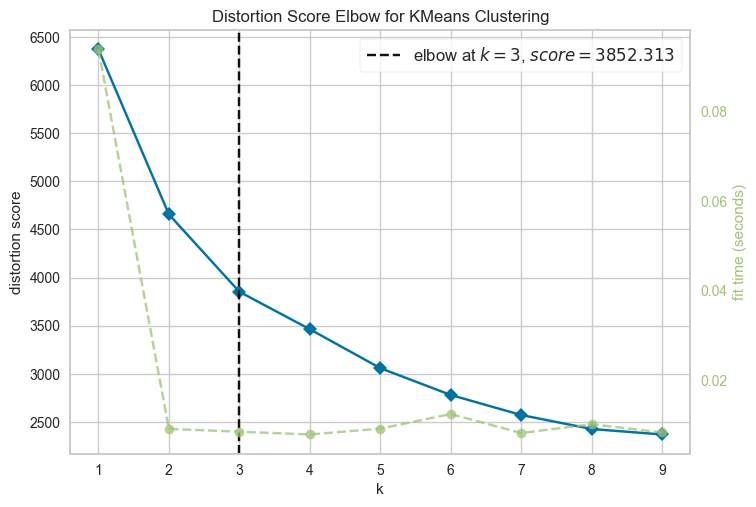

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(1, 10))

visualizer.fit(data_no_outliers)
visualizer.show()

In [11]:
km = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init = 10)
clusters = km.fit_predict(data_no_outliers)

print(km.cluster_centers_)

[[ 0.52254642  0.22811671  0.35278515  0.24668435  0.1061008   0.60212202
   0.92307692 -0.19141732 -0.49946739 -0.50983953 -0.5424202  -0.54554348]
 [ 0.50488599  0.15635179  0.26058632  0.34201954  0.16612378  0.79478827
   2.19218241  0.34081019  0.8192073   0.84521903  0.84807712  0.88039427]
 [ 0.53953488  0.25116279  0.35348837  0.19069767  0.09767442  0.57674419
   3.71627907 -0.27489387 -0.28993721 -0.31214192 -0.27222665 -0.30827123]]


PCA to reduce dimensions and visualise clusters differentiation

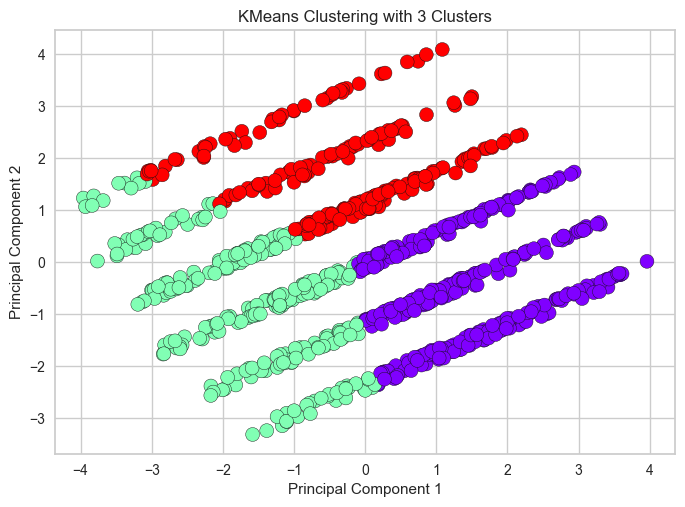

In [12]:
#data_no_outliers['cluster'] = clusters

## PCA to reduce dimensions and visualise clusters differentiation
import matplotlib.pyplot as plt

# Reduce data to 2D
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_no_outliers)

# Plot
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='rainbow', edgecolor='k', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering with 3 Clusters')
plt.show()


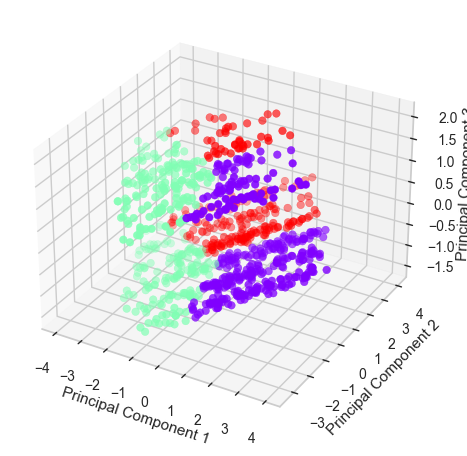

In [16]:
## PCA to reduce dimensions and visualise clusters differentiation

# Reduce data to 3D
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_no_outliers)

# 3D-Plot
graph = plt.figure()
axis = graph.add_subplot(projection="3d")
xdata = data_pca[:, 0]
ydata = data_pca[:, 1]
zdata = data_pca[:, 2]
axis.scatter3D(xdata, ydata, zdata, c=clusters, cmap = "rainbow", s=30)
axis.set_xlabel("Principal Component 1")
axis.set_ylabel("Principal Component 2")
axis.set_zlabel("Principal Component 3")
plt.show()